In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape

In [3]:
stack_idx = '14'
models = '1-22'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = False
add_intercept = True

### Read CV predictions and test

In [4]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [5]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [6]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [7]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [10]:
print('CV predictions:')
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
No. 0 file: model-01-lgb-cv.csv
No. 1 file: model-02-keras-search-cv.csv
No. 2 file: model-03-lgb-feats-selection-cv.csv
No. 3 file: model-04-lgb-PCA-cv.csv
No. 4 file: model-05-lgb-wo-per-area-cv.csv
No. 5 file: model-06-lgb-lr0.001-cv.csv
No. 6 file: model-07-keras-embedding-cv.csv
No. 7 file: model-08-keras-search-long-cv.csv
No. 8 file: model-09-lgb-feats-selection-75-cv.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-cv.csv
No. 10 file: model-11-rf-cv.csv
No. 11 file: model-12-predict-keras-search-prelu-cv.csv
No. 12 file: model-13-predict-keras-he_uni-cv.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
No. 17 file: model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
No. 18 file: model-19-lgb-search-bins-lr-0.0005-cv.csv
No. 19 file: model

In [11]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [12]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_20,log_parea_pred_20,pred_21,log_pred_21,log_parea_pred_21,pred_22,log_pred_22,log_parea_pred_22,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.367018,12.137915,6.959114e+05,13.452979,12.223876,6.949261e+05,13.451562,12.222459,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.969561,13.572994,3.125225e+06,14.955017,13.558450,3.130663e+06,14.956756,13.560188,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.098194,14.378239,9.883518e+06,16.106379,14.386424,9.911790e+06,16.109236,14.389281,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.354260,13.746914,1.282443e+07,16.366863,13.759516,1.279904e+07,16.364881,13.757534,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.933257,12.388231,1.236214e+06,14.027565,12.482539,1.239269e+06,14.030033,12.485007,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_19,pred_20,log_pred_20,log_parea_pred_20,pred_21,log_pred_21,log_parea_pred_21,pred_22,log_pred_22,log_parea_pred_22
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.245864,1.478805e+07,16.509330,15.280223,1.237427e+07,16.331130,15.102023,1.201060e+07,16.301300,15.072193
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.134906,3.918591e+06,15.181243,13.136624,3.933908e+06,15.185144,13.140525,3.933533e+06,15.185049,13.140430
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.686933,1.069408e+07,16.185201,13.686181,1.137126e+07,16.246599,13.747579,1.146014e+07,16.254386,13.755365
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.796868,6.033528e+06,15.612843,14.800910,5.784739e+06,15.570734,14.758802,5.778982e+06,15.569738,14.757806
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.138313,1.089268e+06,13.901017,12.140755,1.010440e+06,13.825898,12.065636,9.995482e+05,13.815060,12.054798


### Check models scores

In [13]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671


In [14]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [15]:
def objective(x, metric):
    cv_pred_final = cv.loc[:,cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    global best_score
    global best_coeffs
    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        print('find better score:')
        print('score: ', score)
        print('coeffs: ', x)
        print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Optimize

In [16]:
best_score = {}
best_coeffs = {}

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [ [1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

for metric in ['mape']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(metric))

Optimizing with init x0: [0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216, 0.043478260869565216]

find better score:
score:  78.53675047000554
coeffs:  [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826]

find better score:
score:  78.53675059042895
coeffs:  [0.04347828 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826

find better score:
score:  5951.876359299575
coeffs:  [ 0.05106334  0.03093275  0.05638414  0.04541993  0.05938615  0.05386839
  0.03080101  0.04704098  0.05225825  0.05671865 -0.08463606  0.03465559
  0.03238685  0.05767014  0.05653387  0.05891763  0.05938311  0.06129841
  0.06186945  0.06060565  0.05968113  0.06013421 -0.04519856]

find better score:
score:  5953.876428803775
coeffs:  [ 0.03949386  0.03428466  0.05341167  0.05320568  0.06003785  0.04692315
  0.03190768  0.06681794  0.04311034  0.05317082 -0.09704203  0.03855283
  0.03955812  0.05540261  0.05271558  0.05834839  0.0593735   0.0645078
  0.06701462  0.06201887  0.05999895  0.06104527 -0.07123812]

find better score:
score:  5953.8764288044995
coeffs:  [ 0.03949387  0.03428466  0.05341167  0.05320568  0.06003785  0.04692315
  0.03190768  0.06681794  0.04311034  0.05317082 -0.09704203  0.03855283
  0.03955812  0.05540261  0.05271558  0.05834839  0.0593735   0.0645078
  0.06701462  0.06201887  0.05999895  0.06104527 -0.0712

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [-0.4096035493256658, -1.4609197991018954, 0.5534630676018372, 0.14384273720636742, -0.057528992824598335, -0.0767525341980644, 0.4465515814159008, 1.6141258181229163, -0.08541470279841168, 0.13395518959533037, 0.15753853084991762, 0.5923280386170299, -1.179983999209791, 2.52997136052468, 0.15718899339677828, -0.9530277329746351, -1.4883678694840545, 0.20225422242457541, -0.8328003905964741, 0.9096457187819099, 0.02663583015788915, 0.17365558909987183, 0.9730277835086291]

Optimizing with init x0: [-0.19539533746772003, 0.23506790898438798, 1.5150400934868704, 0.8601437987631431, 0.8176627076838674, 0.20852678073058922, 0.035435545494691904, -1.8049908058039026, 0.9090618806488727, -0.17567662809728454, 2.108704291467904, -1.0002512952230165, -1.18247115623677, 0.06577845389038178, 0.6505424075593029, -0.22148544296620357, 1.079769877072814, 0.7652051218054462, -0.11275173069887562, -0.7634381034650468, 0.3185389290305135, 0.7588039745810367, -0.660088223850585

In [17]:
display(best_score)
display(best_coeffs)

{'mape': 5958.87646961399}

{'mape': array([ 0.01473348,  0.021356  ,  0.04957415,  0.0744399 ,  0.06315258,
         0.03335919,  0.020445  ,  0.09221276,  0.02454598,  0.04776551,
        -0.07925167,  0.02875374,  0.03917939,  0.05308203,  0.04663859,
         0.05991993,  0.06220073,  0.07499982,  0.08305853,  0.06825285,
         0.0620374 ,  0.06474678, -0.09149878])}

### Compute submission

In [18]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['mape'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}.csv'.format(stack_idx, models), index=False)

### Plots

In [19]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


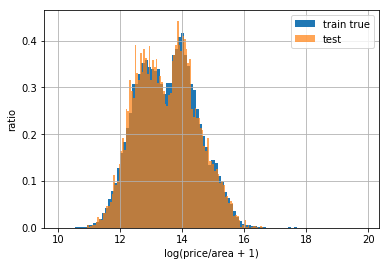

In [20]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

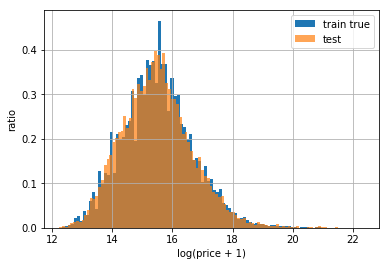

In [21]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

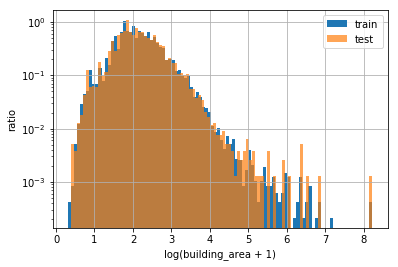

In [22]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()